# Ajuste de hiperparâmetros com Optuna

Agora que identificamos o modelo com melhor desempenho, avançamos para a próxima etapa do projeto: o ajuste fino dos hiperparâmetros.

Uma abordagem bastante comum para esse processo é a grid search, que avalia sistematicamente todas as combinações possíveis dentro de um espaço pré-definido. No entanto, essa estratégia pode ser limitada, pois segue um padrão fixo e não explora de forma eficiente as regiões mais promissoras do espaço de hiperparâmetros.

No [artigo](https://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf) de James Bergstra e Yoshua Bengio, é demonstrado que a random search tende a ser mais eficaz do que a grid search, pois distribui as tentativas de forma aleatória, cobrindo uma área maior e aumentando as chances de encontrar configurações mais otimizadas.

![Diagram comparing grid search and random search](../docs/optuna.png)

Source: Bergstra et al. (2012)

No diagrama acima, vemos a **busca em grade** à esquerda e a **busca aleatória** à direita, ambas com nove tentativas (pontos pretos) e dois parâmetros. A área verde indica o ganho de desempenho ao ajustar o parâmetro mais relevante, enquanto a área amarela representa o impacto de um parâmetro menos importante. O que fica claro é que, enquanto a **grid search** faz avaliações ordenadas, a **random search** consegue explorar o espaço de forma mais ampla, aumentando a probabilidade de encontrar combinações melhores.  

Porém, mesmo a **busca aleatória** pode ser aprimorada. Sabemos que, em um espaço de hiperparâmetros, **regiões próximas tendem a gerar desempenhos semelhantes**. É aí que entra a **Otimização Bayesiana**, que utiliza esse comportamento para priorizar a exploração de áreas mais promissoras. O algoritmo **Tree of Parzen Estimators (TPE)** é um dos métodos que seguem essa abordagem, tornando o processo ainda mais eficiente.  

Agora que identificamos o modelo com melhor desempenho, podemos usar o **Optuna** para buscar a melhor configuração de hiperparâmetros com o algoritmo **TPE**. Este [artigo](https://towardsdatascience.com/hyperparameter-tuning-a-practical-guide-and-template-b3bf0504f095) traz uma explicação mais detalhada sobre **TPE** e **ajuste de hiperparâmetros**.

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

In [3]:
import time
import warnings
import os

import joblib
import lightning.pytorch as pl
import optuna
import pandas as pd
from optuna.visualization.matplotlib import plot_param_importances
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer

from src.treinamento_modelo import expanding_window_split
from src.otimizacao_hiperparametro import otimizar_tft

# Reduzindo logs do Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

warnings.filterwarnings("ignore")

In [2]:
# Carregando os dados processados
df_sales_processed = pd.read_parquet("../data/processed/sales_cleaning_processed.parquet")
df_sales_processed.set_index("date", inplace=True)

In [3]:
# Verificando os dados
print(df_sales_processed.head())

           store_id cat_id    sales  in_training
date                                            
2011-01-29     CA_1  FOODS  7240.65         True
2011-01-30     CA_1  FOODS  6705.51         True
2011-01-31     CA_1  FOODS  4584.85         True
2011-02-01     CA_1  FOODS  4965.46         True
2011-02-02     CA_1  FOODS  4368.07         True


In [5]:
df_sales_processed_transformer = df_sales_processed.copy()
df_sales_processed_transformer["series_id"] = df_sales_processed_transformer["store_id"] + "_" + df_sales_processed_transformer["cat_id"]
df_sales_processed_transformer = df_sales_processed_transformer[df_sales_processed_transformer["series_id"] == "CA_1_FOODS"]
df_sales_processed_transformer.reset_index(inplace=True, drop=False)
df_sales_processed_transformer["time_idx"] = (
    df_sales_processed_transformer["date"] - df_sales_processed_transformer["date"].min()
).dt.days

df_sales_processed_transformer.head(3)

,date,store_id,cat_id,sales,in_training,series_id,time_idx
0,2011-01-29,CA_1,FOODS,7240.65,True,CA_1_FOODS,0
1,2011-01-30,CA_1,FOODS,6705.51,True,CA_1_FOODS,1
2,2011-01-31,CA_1,FOODS,4584.85,True,CA_1_FOODS,2


Estamos utilizando o **PyTorch Forecasting** sobre o **PyTorch Lightning**, o que torna a modificação direta do código um pouco mais complexa. No entanto, ainda podemos registrar a métrica de validação em **hp_metric** utilizando um **callback**.  

Anteriormente, já implementamos um **ModelCheckpoint callback** para monitorar a perda na validação e salvar o melhor checkpoint. Agora, vamos criar um callback que será acionado ao final de cada etapa de validação para atualizar o **hp_metric** com a menor perda obtida.  

Com base na [documentação oficial do PyTorch Lightning sobre callbacks](https://pytorch-lightning.readthedocs.io/en/latest/extensions/callbacks.html#), criamos a classe **ModifyHPMetric**, que tem como objetivo modificar diretamente o **hp_metric** com a perda da validação. Dessa forma, garantimos que a métrica de desempenho seja corretamente registrada e utilizada para futuras otimizações. 🚀

GPU available: True (cuda), used: True


Suggested Learning Rate: 2.951209226666385e-05
Adjusted LR Range for Optuna: 5.90241845333277e-06 - 0.00014756046133331926


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1958.4500, device='cuda:0'), 'sanity_check_MAE': tensor(1688.5502, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1737, device='cuda:0'), 'sanity_check_RMSE': tensor(2369.0186, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2038, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(820.3440, device='cuda:0'), 'train_loss_step': tensor(820.3440, device='cuda:0'), 'val_loss': tensor(898.1819, device='cuda:0'), 'val_MAE': tensor(1487.7020, device='cuda:0'), 'val_MAPE': tensor(0.1594, device='cuda:0'), 'val_RMSE': tensor(2007.9764, device='cuda:0'), 'val_SMAPE': tensor(0.1763, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2238.9670, device='cuda:0'), 'sanity_check_MAE': tensor(1872.9373, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1948, device='cuda:0'), 'sanity_check_RMSE': tensor(2540.9062, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2310, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(1002.2924, device='cuda:0'), 'train_loss_step': tensor(1002.2924, device='cuda:0'), 'val_loss': tensor(1365.9156, device='cuda:0'), 'val_MAE': tensor(1644.1320, device='cuda:0'), 'val_MAPE': tensor(0.1693, device='cuda:0'), 'val_RMSE': tensor(2315.7964, device='cuda:0'), 'val_SMAPE': tensor(0.1974, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1348.9735, device='cuda:0'), 'sanity_check_MAE': tensor(1468.1708, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1686, device='cuda:0'), 'sanity_check_RMSE': tensor(1819.0752, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1742, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(812.3688, device='cuda:0'), 'train_loss_step': tensor(812.3688, device='cuda:0'), 'val_loss': tensor(939.0082, device='cuda:0'), 'val_MAE': tensor(1547.4584, device='cuda:0'), 'val_MAPE': tensor(0.1630, device='cuda:0'), 'val_RMSE': tensor(2122.3760, device='cuda:0'), 'val_SMAPE': tensor(0.1842, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1271.9974, device='cuda:0'), 'sanity_check_MAE': tensor(1723.0668, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1776, device='cuda:0'), 'sanity_check_RMSE': tensor(2403.2273, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2088, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(790.8566, device='cuda:0'), 'train_loss_step': tensor(790.8566, device='cuda:0'), 'val_loss': tensor(948.1914, device='cuda:0'), 'val_MAE': tensor(1594.1887, device='cuda:0'), 'val_MAPE': tensor(0.1645, device='cuda:0'), 'val_RMSE': tensor(2244.0791, device='cuda:0'), 'val_SMAPE': tensor(0.1904, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2258.9558, device='cuda:0'), 'sanity_check_MAE': tensor(2184.1814, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2326, device='cuda:0'), 'sanity_check_RMSE': tensor(2794.1843, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2790, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(1025.2441, device='cuda:0'), 'train_loss_step': tensor(1025.2441, device='cuda:0'), 'val_loss': tensor(1186.8934, device='cuda:0'), 'val_MAE': tensor(1793.2015, device='cuda:0'), 'val_MAPE': tensor(0.1855, device='cuda:0'), 'val_RMSE': tensor(2469.2354, device='cuda:0'), 'val_SMAPE': tensor(0.2191, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1120.7999, device='cuda:0'), 'sanity_check_MAE': tensor(1520.2052, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1623, device='cuda:0'), 'sanity_check_RMSE': tensor(2052.5801, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1806, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(814.3375, device='cuda:0'), 'train_loss_step': tensor(814.3375, device='cuda:0'), 'val_loss': tensor(991.7106, device='cuda:0'), 'val_MAE': tensor(1618.1420, device='cuda:0'), 'val_MAPE': tensor(0.1669, device='cuda:0'), 'val_RMSE': tensor(2278.3931, device='cuda:0'), 'val_SMAPE': tensor(0.1938, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1759.8184, device='cuda:0'), 'sanity_check_MAE': tensor(1767.9353, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1825, device='cuda:0'), 'sanity_check_RMSE': tensor(2449.1460, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2153, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(809.3301, device='cuda:0'), 'train_loss_step': tensor(809.3301, device='cuda:0'), 'val_loss': tensor(967.5488, device='cuda:0'), 'val_MAE': tensor(1557.6595, device='cuda:0'), 'val_MAPE': tensor(0.1622, device='cuda:0'), 'val_RMSE': tensor(2172.1787, device='cuda:0'), 'val_SMAPE': tensor(0.1854, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1808.2692, device='cuda:0'), 'sanity_check_MAE': tensor(1519.8856, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1830, device='cuda:0'), 'sanity_check_RMSE': tensor(1778.0817, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1807, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(853.6998, device='cuda:0'), 'train_loss_step': tensor(853.6998, device='cuda:0'), 'val_loss': tensor(1021.1215, device='cuda:0'), 'val_MAE': tensor(1512.2195, device='cuda:0'), 'val_MAPE': tensor(0.1621, device='cuda:0'), 'val_RMSE': tensor(2033.9658, device='cuda:0'), 'val_SMAPE': tensor(0.1796, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1294.6025, device='cuda:0'), 'sanity_check_MAE': tensor(1531.1768, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1636, device='cuda:0'), 'sanity_check_RMSE': tensor(2065.3230, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1821, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(799.4933, device='cuda:0'), 'train_loss_step': tensor(799.4933, device='cuda:0'), 'val_loss': tensor(1075.4758, device='cuda:0'), 'val_MAE': tensor(1578.7810, device='cuda:0'), 'val_MAPE': tensor(0.1644, device='cuda:0'), 'val_RMSE': tensor(2199.2764, device='cuda:0'), 'val_SMAPE': tensor(0.1884, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2049.6323, device='cuda:0'), 'sanity_check_MAE': tensor(1532.1775, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1628, device='cuda:0'), 'sanity_check_RMSE': tensor(2078.9688, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1822, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(876.3757, device='cuda:0'), 'train_loss_step': tensor(876.3757, device='cuda:0'), 'val_loss': tensor(1043.2208, device='cuda:0'), 'val_MAE': tensor(1506.1263, device='cuda:0'), 'val_MAPE': tensor(0.1618, device='cuda:0'), 'val_RMSE': tensor(2021.0537, device='cuda:0'), 'val_SMAPE': tensor(0.1788, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1299.5165, device='cuda:0'), 'sanity_check_MAE': tensor(1532.6886, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1619, device='cuda:0'), 'sanity_check_RMSE': tensor(2096.0002, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1822, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(802.2305, device='cuda:0'), 'train_loss_step': tensor(802.2305, device='cuda:0'), 'val_loss': tensor(959.2803, device='cuda:0'), 'val_MAE': tensor(1560.3326, device='cuda:0'), 'val_MAPE': tensor(0.1626, device='cuda:0'), 'val_RMSE': tensor(2173.0410, device='cuda:0'), 'val_SMAPE': tensor(0.1858, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1457.9991, device='cuda:0'), 'sanity_check_MAE': tensor(1898.6083, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1979, device='cuda:0'), 'sanity_check_RMSE': tensor(2560.7849, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2348, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(774.7992, device='cuda:0'), 'train_loss_step': tensor(774.7992, device='cuda:0'), 'val_loss': tensor(962.9121, device='cuda:0'), 'val_MAE': tensor(1534.8391, device='cuda:0'), 'val_MAPE': tensor(0.1623, device='cuda:0'), 'val_RMSE': tensor(2096.2266, device='cuda:0'), 'val_SMAPE': tensor(0.1825, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1816.5411, device='cuda:0'), 'sanity_check_MAE': tensor(1751.1071, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1807, device='cuda:0'), 'sanity_check_RMSE': tensor(2432.7363, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2129, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(815.6608, device='cuda:0'), 'train_loss_step': tensor(815.6608, device='cuda:0'), 'val_loss': tensor(984.1893, device='cuda:0'), 'val_MAE': tensor(1515.9092, device='cuda:0'), 'val_MAPE': tensor(0.1623, device='cuda:0'), 'val_RMSE': tensor(2039.5087, device='cuda:0'), 'val_SMAPE': tensor(0.1801, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1375.0360, device='cuda:0'), 'sanity_check_MAE': tensor(1541.9111, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1628, device='cuda:0'), 'sanity_check_RMSE': tensor(2110.2363, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1835, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(772.1073, device='cuda:0'), 'train_loss_step': tensor(772.1073, device='cuda:0'), 'val_loss': tensor(941.8525, device='cuda:0'), 'val_MAE': tensor(1557.0771, device='cuda:0'), 'val_MAPE': tensor(0.1623, device='cuda:0'), 'val_RMSE': tensor(2168.5215, device='cuda:0'), 'val_SMAPE': tensor(0.1854, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2236.3074, device='cuda:0'), 'sanity_check_MAE': tensor(1482.2196, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1606, device='cuda:0'), 'sanity_check_RMSE': tensor(1975.1179, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1757, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(823.5602, device='cuda:0'), 'train_loss_step': tensor(823.5602, device='cuda:0'), 'val_loss': tensor(1083.4142, device='cuda:0'), 'val_MAE': tensor(1530.2634, device='cuda:0'), 'val_MAPE': tensor(0.1615, device='cuda:0'), 'val_RMSE': tensor(2096.8867, device='cuda:0'), 'val_SMAPE': tensor(0.1819, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1388.8854, device='cuda:0'), 'sanity_check_MAE': tensor(1473.4799, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1648, device='cuda:0'), 'sanity_check_RMSE': tensor(1881.9667, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1748, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(749.4275, device='cuda:0'), 'train_loss_step': tensor(749.4275, device='cuda:0'), 'val_loss': tensor(1028.2014, device='cuda:0'), 'val_MAE': tensor(1577.0703, device='cuda:0'), 'val_MAPE': tensor(0.1641, device='cuda:0'), 'val_RMSE': tensor(2199.8296, device='cuda:0'), 'val_SMAPE': tensor(0.1881, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1398.3512, device='cuda:0'), 'sanity_check_MAE': tensor(1479.6815, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1622, device='cuda:0'), 'sanity_check_RMSE': tensor(1940.2902, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1754, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(768.0548, device='cuda:0'), 'train_loss_step': tensor(768.0548, device='cuda:0'), 'val_loss': tensor(953.6212, device='cuda:0'), 'val_MAE': tensor(1549.3018, device='cuda:0'), 'val_MAPE': tensor(0.1613, device='cuda:0'), 'val_RMSE': tensor(2157.9463, device='cuda:0'), 'val_SMAPE': tensor(0.1843, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1754.5403, device='cuda:0'), 'sanity_check_MAE': tensor(1478.4388, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1635, device='cuda:0'), 'sanity_check_RMSE': tensor(1916.6584, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1753, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(841.2849, device='cuda:0'), 'train_loss_step': tensor(841.2849, device='cuda:0'), 'val_loss': tensor(959.3093, device='cuda:0'), 'val_MAE': tensor(1541.8893, device='cuda:0'), 'val_MAPE': tensor(0.1631, device='cuda:0'), 'val_RMSE': tensor(2103.0833, device='cuda:0'), 'val_SMAPE': tensor(0.1835, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2151.1736, device='cuda:0'), 'sanity_check_MAE': tensor(2326.0693, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2498, device='cuda:0'), 'sanity_check_RMSE': tensor(2917.3984, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.3016, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(790.3287, device='cuda:0'), 'train_loss_step': tensor(790.3287, device='cuda:0'), 'val_loss': tensor(954.9889, device='cuda:0'), 'val_MAE': tensor(1582.9581, device='cuda:0'), 'val_MAPE': tensor(0.1643, device='cuda:0'), 'val_RMSE': tensor(2216.1641, device='cuda:0'), 'val_SMAPE': tensor(0.1889, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1536.7246, device='cuda:0'), 'sanity_check_MAE': tensor(1475.4945, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1628, device='cuda:0'), 'sanity_check_RMSE': tensor(1919.6772, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1749, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(800.6640, device='cuda:0'), 'train_loss_step': tensor(800.6640, device='cuda:0'), 'val_loss': tensor(952.2475, device='cuda:0'), 'val_MAE': tensor(1545.1022, device='cuda:0'), 'val_MAPE': tensor(0.1626, device='cuda:0'), 'val_RMSE': tensor(2122.2554, device='cuda:0'), 'val_SMAPE': tensor(0.1839, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1218.9347, device='cuda:0'), 'sanity_check_MAE': tensor(1763.6302, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2298, device='cuda:0'), 'sanity_check_RMSE': tensor(1932.5741, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2083, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(816.3439, device='cuda:0'), 'train_loss_step': tensor(816.3439, device='cuda:0'), 'val_loss': tensor(1012.6265, device='cuda:0'), 'val_MAE': tensor(1645.9277, device='cuda:0'), 'val_MAPE': tensor(0.1694, device='cuda:0'), 'val_RMSE': tensor(2317.7786, device='cuda:0'), 'val_SMAPE': tensor(0.1977, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1706.5338, device='cuda:0'), 'sanity_check_MAE': tensor(1507.6837, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1611, device='cuda:0'), 'sanity_check_RMSE': tensor(2035.7861, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1790, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(804.6904, device='cuda:0'), 'train_loss_step': tensor(804.6904, device='cuda:0'), 'val_loss': tensor(1079.5659, device='cuda:0'), 'val_MAE': tensor(1511.1936, device='cuda:0'), 'val_MAPE': tensor(0.1611, device='cuda:0'), 'val_RMSE': tensor(2046.0277, device='cuda:0'), 'val_SMAPE': tensor(0.1794, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2370.4458, device='cuda:0'), 'sanity_check_MAE': tensor(1786.6093, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1847, device='cuda:0'), 'sanity_check_RMSE': tensor(2465.7966, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2181, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(815.7433, device='cuda:0'), 'train_loss_step': tensor(815.7433, device='cuda:0'), 'val_loss': tensor(996.4139, device='cuda:0'), 'val_MAE': tensor(1511.9900, device='cuda:0'), 'val_MAPE': tensor(0.1611, device='cuda:0'), 'val_RMSE': tensor(2048.8748, device='cuda:0'), 'val_SMAPE': tensor(0.1795, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1473.8516, device='cuda:0'), 'sanity_check_MAE': tensor(1560.0731, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1632, device='cuda:0'), 'sanity_check_RMSE': tensor(2159.4263, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1858, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(776.0854, device='cuda:0'), 'train_loss_step': tensor(776.0854, device='cuda:0'), 'val_loss': tensor(978.5963, device='cuda:0'), 'val_MAE': tensor(1535.4827, device='cuda:0'), 'val_MAPE': tensor(0.1625, device='cuda:0'), 'val_RMSE': tensor(2094.9490, device='cuda:0'), 'val_SMAPE': tensor(0.1826, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1591.3385, device='cuda:0'), 'sanity_check_MAE': tensor(1551.5010, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1901, device='cuda:0'), 'sanity_check_RMSE': tensor(1778.4387, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1845, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(796.8082, device='cuda:0'), 'train_loss_step': tensor(796.8082, device='cuda:0'), 'val_loss': tensor(1022.1979, device='cuda:0'), 'val_MAE': tensor(1577.1758, device='cuda:0'), 'val_MAPE': tensor(0.1644, device='cuda:0'), 'val_RMSE': tensor(2193.2170, device='cuda:0'), 'val_SMAPE': tensor(0.1882, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1291.6174, device='cuda:0'), 'sanity_check_MAE': tensor(1476.2709, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1595, device='cuda:0'), 'sanity_check_RMSE': tensor(1975.9421, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1749, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(760.0696, device='cuda:0'), 'train_loss_step': tensor(760.0696, device='cuda:0'), 'val_loss': tensor(948.3423, device='cuda:0'), 'val_MAE': tensor(1522.9597, device='cuda:0'), 'val_MAPE': tensor(0.1601, device='cuda:0'), 'val_RMSE': tensor(2099.9893, device='cuda:0'), 'val_SMAPE': tensor(0.1808, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1886.3446, device='cuda:0'), 'sanity_check_MAE': tensor(1765.6350, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2301, device='cuda:0'), 'sanity_check_RMSE': tensor(1934.5371, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2085, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1121.3207, device='cuda:0'), 'train_loss_step': tensor(1121.3207, device='cuda:0'), 'val_loss': tensor(1416.4330, device='cuda:0'), 'val_MAE': tensor(1534.2285, device='cuda:0'), 'val_MAPE': tensor(0.1862, device='cuda:0'), 'val_RMSE': tensor(1778.8708, device='cuda:0'), 'val_SMAPE': tensor(0.1825, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1252.9688, device='cuda:0'), 'sanity_check_MAE': tensor(1477.9709, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1649, device='cuda:0'), 'sanity_check_RMSE': tensor(1893.8618, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1753, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(802.1453, device='cuda:0'), 'train_loss_step': tensor(802.1453, device='cuda:0'), 'val_loss': tensor(967.6774, device='cuda:0'), 'val_MAE': tensor(1602.1292, device='cuda:0'), 'val_MAPE': tensor(0.1659, device='cuda:0'), 'val_RMSE': tensor(2245.5706, device='cuda:0'), 'val_SMAPE': tensor(0.1916, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(998.2992, device='cuda:0'), 'sanity_check_MAE': tensor(1644.3933, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1692, device='cuda:0'), 'sanity_check_RMSE': tensor(2316.2458, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1975, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(811.8917, device='cuda:0'), 'train_loss_step': tensor(811.8917, device='cuda:0'), 'val_loss': tensor(945.4456, device='cuda:0'), 'val_MAE': tensor(1546.8878, device='cuda:0'), 'val_MAPE': tensor(0.1619, device='cuda:0'), 'val_RMSE': tensor(2143.3054, device='cuda:0'), 'val_SMAPE': tensor(0.1840, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1467.4967, device='cuda:0'), 'sanity_check_MAE': tensor(1639.0118, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1687, device='cuda:0'), 'sanity_check_RMSE': tensor(2309.1765, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1967, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(810.0524, device='cuda:0'), 'train_loss_step': tensor(810.0524, device='cuda:0'), 'val_loss': tensor(947.1689, device='cuda:0'), 'val_MAE': tensor(1508.0095, device='cuda:0'), 'val_MAPE': tensor(0.1603, device='cuda:0'), 'val_RMSE': tensor(2051.6599, device='cuda:0'), 'val_SMAPE': tensor(0.1789, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2046.5801, device='cuda:0'), 'sanity_check_MAE': tensor(1539.8109, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1624, device='cuda:0'), 'sanity_check_RMSE': tensor(2109.2322, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1832, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(867.3789, device='cuda:0'), 'train_loss_step': tensor(867.3789, device='cuda:0'), 'val_loss': tensor(988.3527, device='cuda:0'), 'val_MAE': tensor(1491.6827, device='cuda:0'), 'val_MAPE': tensor(0.1606, device='cuda:0'), 'val_RMSE': tensor(1999.6921, device='cuda:0'), 'val_SMAPE': tensor(0.1769, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1886.4894, device='cuda:0'), 'sanity_check_MAE': tensor(1685.1035, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1733, device='cuda:0'), 'sanity_check_RMSE': tensor(2366.1213, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2033, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(833.5169, device='cuda:0'), 'train_loss_step': tensor(833.5169, device='cuda:0'), 'val_loss': tensor(966.4072, device='cuda:0'), 'val_MAE': tensor(1505.2284, device='cuda:0'), 'val_MAPE': tensor(0.1616, device='cuda:0'), 'val_RMSE': tensor(2020.3716, device='cuda:0'), 'val_SMAPE': tensor(0.1787, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1263.6459, device='cuda:0'), 'sanity_check_MAE': tensor(1527.7126, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1847, device='cuda:0'), 'sanity_check_RMSE': tensor(1775.8807, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1817, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(800.1165, device='cuda:0'), 'train_loss_step': tensor(800.1165, device='cuda:0'), 'val_loss': tensor(1010.3649, device='cuda:0'), 'val_MAE': tensor(1581.1154, device='cuda:0'), 'val_MAPE': tensor(0.1648, device='cuda:0'), 'val_RMSE': tensor(2197.7673, device='cuda:0'), 'val_SMAPE': tensor(0.1887, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1880.2928, device='cuda:0'), 'sanity_check_MAE': tensor(1593.4965, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1994, device='cuda:0'), 'sanity_check_RMSE': tensor(1802.2682, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1894, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(837.9789, device='cuda:0'), 'train_loss_step': tensor(837.9789, device='cuda:0'), 'val_loss': tensor(1004.8373, device='cuda:0'), 'val_MAE': tensor(1608.3440, device='cuda:0'), 'val_MAPE': tensor(0.1664, device='cuda:0'), 'val_RMSE': tensor(2258.0286, device='cuda:0'), 'val_SMAPE': tensor(0.1924, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1096.8500, device='cuda:0'), 'sanity_check_MAE': tensor(1474.5951, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1695, device='cuda:0'), 'sanity_check_RMSE': tensor(1824.5618, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1750, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(804.2800, device='cuda:0'), 'train_loss_step': tensor(804.2800, device='cuda:0'), 'val_loss': tensor(974.8353, device='cuda:0'), 'val_MAE': tensor(1570.5619, device='cuda:0'), 'val_MAPE': tensor(0.1637, device='cuda:0'), 'val_RMSE': tensor(2186.7778, device='cuda:0'), 'val_SMAPE': tensor(0.1872, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1528.5804, device='cuda:0'), 'sanity_check_MAE': tensor(1535.4286, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1621, device='cuda:0'), 'sanity_check_RMSE': tensor(2101.5825, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1826, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(851.6889, device='cuda:0'), 'train_loss_step': tensor(851.6889, device='cuda:0'), 'val_loss': tensor(1022.7938, device='cuda:0'), 'val_MAE': tensor(1505.2938, device='cuda:0'), 'val_MAPE': tensor(0.1607, device='cuda:0'), 'val_RMSE': tensor(2036.3169, device='cuda:0'), 'val_SMAPE': tensor(0.1786, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1404.1227, device='cuda:0'), 'sanity_check_MAE': tensor(1632.0326, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2072, device='cuda:0'), 'sanity_check_RMSE': tensor(1829.6597, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1938, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(828.5947, device='cuda:0'), 'train_loss_step': tensor(828.5947, device='cuda:0'), 'val_loss': tensor(1026.2704, device='cuda:0'), 'val_MAE': tensor(1623.9529, device='cuda:0'), 'val_MAPE': tensor(0.1675, device='cuda:0'), 'val_RMSE': tensor(2285.3657, device='cuda:0'), 'val_SMAPE': tensor(0.1946, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1483.1730, device='cuda:0'), 'sanity_check_MAE': tensor(1508.9718, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1803, device='cuda:0'), 'sanity_check_RMSE': tensor(1779.8789, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1794, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(813.0499, device='cuda:0'), 'train_loss_step': tensor(813.0499, device='cuda:0'), 'val_loss': tensor(1063.4524, device='cuda:0'), 'val_MAE': tensor(1564.8127, device='cuda:0'), 'val_MAPE': tensor(0.1638, device='cuda:0'), 'val_RMSE': tensor(2165.7146, device='cuda:0'), 'val_SMAPE': tensor(0.1865, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1586.9515, device='cuda:0'), 'sanity_check_MAE': tensor(1708.3831, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2205, device='cuda:0'), 'sanity_check_RMSE': tensor(1883.1685, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2023, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(826.3836, device='cuda:0'), 'train_loss_step': tensor(826.3836, device='cuda:0'), 'val_loss': tensor(1026.8916, device='cuda:0'), 'val_MAE': tensor(1826.4012, device='cuda:0'), 'val_MAPE': tensor(0.1893, device='cuda:0'), 'val_RMSE': tensor(2499.8767, device='cuda:0'), 'val_SMAPE': tensor(0.2240, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2501.7710, device='cuda:0'), 'sanity_check_MAE': tensor(1506.5094, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1611, device='cuda:0'), 'sanity_check_RMSE': tensor(2032.8879, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1788, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(785.7629, device='cuda:0'), 'train_loss_step': tensor(785.7629, device='cuda:0'), 'val_loss': tensor(956.5463, device='cuda:0'), 'val_MAE': tensor(1477.6417, device='cuda:0'), 'val_MAPE': tensor(0.1614, device='cuda:0'), 'val_RMSE': tensor(1946.8163, device='cuda:0'), 'val_SMAPE': tensor(0.1751, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2507.7473, device='cuda:0'), 'sanity_check_MAE': tensor(2008.2734, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2110, device='cuda:0'), 'sanity_check_RMSE': tensor(2653.6650, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2515, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(799.9897, device='cuda:0'), 'train_loss_step': tensor(799.9897, device='cuda:0'), 'val_loss': tensor(909.9087, device='cuda:0'), 'val_MAE': tensor(1522.3108, device='cuda:0'), 'val_MAPE': tensor(0.1607, device='cuda:0'), 'val_RMSE': tensor(2087.2566, device='cuda:0'), 'val_SMAPE': tensor(0.1808, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1698.9586, device='cuda:0'), 'sanity_check_MAE': tensor(1476.5656, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1701, device='cuda:0'), 'sanity_check_RMSE': tensor(1823.8845, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1753, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(861.5846, device='cuda:0'), 'train_loss_step': tensor(861.5846, device='cuda:0'), 'val_loss': tensor(1054.1757, device='cuda:0'), 'val_MAE': tensor(1566.2815, device='cuda:0'), 'val_MAPE': tensor(0.1640, device='cuda:0'), 'val_RMSE': tensor(2165.1755, device='cuda:0'), 'val_SMAPE': tensor(0.1867, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1148.5098, device='cuda:0'), 'sanity_check_MAE': tensor(1471.4529, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1699, device='cuda:0'), 'sanity_check_RMSE': tensor(1812.1624, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1747, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(832.8412, device='cuda:0'), 'train_loss_step': tensor(832.8412, device='cuda:0'), 'val_loss': tensor(987.4398, device='cuda:0'), 'val_MAE': tensor(1544.3503, device='cuda:0'), 'val_MAPE': tensor(0.1631, device='cuda:0'), 'val_RMSE': tensor(2113.2102, device='cuda:0'), 'val_SMAPE': tensor(0.1838, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1733.7394, device='cuda:0'), 'sanity_check_MAE': tensor(1474.7792, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1609, device='cuda:0'), 'sanity_check_RMSE': tensor(1946.7313, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1748, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(877.9907, device='cuda:0'), 'train_loss_step': tensor(877.9907, device='cuda:0'), 'val_loss': tensor(973.4904, device='cuda:0'), 'val_MAE': tensor(1546.0070, device='cuda:0'), 'val_MAPE': tensor(0.1624, device='cuda:0'), 'val_RMSE': tensor(2130.2605, device='cuda:0'), 'val_SMAPE': tensor(0.1840, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2253.8013, device='cuda:0'), 'sanity_check_MAE': tensor(2989.8472, device='cuda:0'), 'sanity_check_MAPE': tensor(0.3329, device='cuda:0'), 'sanity_check_RMSE': tensor(3474.8491, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.4145, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(846.9551, device='cuda:0'), 'train_loss_step': tensor(846.9551, device='cuda:0'), 'val_loss': tensor(1011.1806, device='cuda:0'), 'val_MAE': tensor(1531.4264, device='cuda:0'), 'val_MAPE': tensor(0.1616, device='cuda:0'), 'val_RMSE': tensor(2099.4009, device='cuda:0'), 'val_SMAPE': tensor(0.1820, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1680.0801, device='cuda:0'), 'sanity_check_MAE': tensor(2793.2161, device='cuda:0'), 'sanity_check_MAPE': tensor(0.3080, device='cuda:0'), 'sanity_check_RMSE': tensor(3310.4985, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.3798, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(822.8387, device='cuda:0'), 'train_loss_step': tensor(822.8387, device='cuda:0'), 'val_loss': tensor(920.3936, device='cuda:0'), 'val_MAE': tensor(1462.8665, device='cuda:0'), 'val_MAPE': tensor(0.1640, device='cuda:0'), 'val_RMSE': tensor(1863.5352, device='cuda:0'), 'val_SMAPE': tensor(0.1734, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1565.2394, device='cuda:0'), 'sanity_check_MAE': tensor(1475.0859, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1650, device='cuda:0'), 'sanity_check_RMSE': tensor(1883.4641, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1750, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(846.0423, device='cuda:0'), 'train_loss_step': tensor(846.0423, device='cuda:0'), 'val_loss': tensor(982.9057, device='cuda:0'), 'val_MAE': tensor(1569.4763, device='cuda:0'), 'val_MAPE': tensor(0.1632, device='cuda:0'), 'val_RMSE': tensor(2190.4236, device='cuda:0'), 'val_SMAPE': tensor(0.1871, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1547.2321, device='cuda:0'), 'sanity_check_MAE': tensor(1973.5834, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2069, device='cuda:0'), 'sanity_check_RMSE': tensor(2622.7217, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2462, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(842.4752, device='cuda:0'), 'train_loss_step': tensor(842.4752, device='cuda:0'), 'val_loss': tensor(966.6390, device='cuda:0'), 'val_MAE': tensor(1543.0729, device='cuda:0'), 'val_MAPE': tensor(0.1626, device='cuda:0'), 'val_RMSE': tensor(2115.9778, device='cuda:0'), 'val_SMAPE': tensor(0.1836, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1913.5232, device='cuda:0'), 'sanity_check_MAE': tensor(1856.2103, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1930, device='cuda:0'), 'sanity_check_RMSE': tensor(2520.1716, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2285, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(791.7510, device='cuda:0'), 'train_loss_step': tensor(791.7510, device='cuda:0'), 'val_loss': tensor(905.5656, device='cuda:0'), 'val_MAE': tensor(1501.3186, device='cuda:0'), 'val_MAPE': tensor(0.1589, device='cuda:0'), 'val_RMSE': tensor(2056.0627, device='cuda:0'), 'val_SMAPE': tensor(0.1780, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1272.3639, device='cuda:0'), 'sanity_check_MAE': tensor(1467.3887, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1669, device='cuda:0'), 'sanity_check_RMSE': tensor(1836.6030, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1741, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(770.6901, device='cuda:0'), 'train_loss_step': tensor(770.6901, device='cuda:0'), 'val_loss': tensor(948.2634, device='cuda:0'), 'val_MAE': tensor(1576.0739, device='cuda:0'), 'val_MAPE': tensor(0.1632, device='cuda:0'), 'val_RMSE': tensor(2210.3096, device='cuda:0'), 'val_SMAPE': tensor(0.1880, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2215.2405, device='cuda:0'), 'sanity_check_MAE': tensor(1468.3802, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1612, device='cuda:0'), 'sanity_check_RMSE': tensor(1923.9916, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1740, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(803.6596, device='cuda:0'), 'train_loss_step': tensor(803.6596, device='cuda:0'), 'val_loss': tensor(980.6517, device='cuda:0'), 'val_MAE': tensor(1658.0869, device='cuda:0'), 'val_MAPE': tensor(0.1705, device='cuda:0'), 'val_RMSE': tensor(2332.2334, device='cuda:0'), 'val_SMAPE': tensor(0.1994, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1396.3613, device='cuda:0'), 'sanity_check_MAE': tensor(1472.3680, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1620, device='cuda:0'), 'sanity_check_RMSE': tensor(1921.8883, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1745, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(789.7085, device='cuda:0'), 'train_loss_step': tensor(789.7085, device='cuda:0'), 'val_loss': tensor(944.6266, device='cuda:0'), 'val_MAE': tensor(1531.7961, device='cuda:0'), 'val_MAPE': tensor(0.1612, device='cuda:0'), 'val_RMSE': tensor(2107.6062, device='cuda:0'), 'val_SMAPE': tensor(0.1820, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1195.5006, device='cuda:0'), 'sanity_check_MAE': tensor(1469.2034, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1657, device='cuda:0'), 'sanity_check_RMSE': tensor(1856.8687, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1743, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(806.1842, device='cuda:0'), 'train_loss_step': tensor(806.1842, device='cuda:0'), 'val_loss': tensor(978.5198, device='cuda:0'), 'val_MAE': tensor(1624.5050, device='cuda:0'), 'val_MAPE': tensor(0.1675, device='cuda:0'), 'val_RMSE': tensor(2287.3335, device='cuda:0'), 'val_SMAPE': tensor(0.1947, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1180.9169, device='cuda:0'), 'sanity_check_MAE': tensor(1507.3492, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1806, device='cuda:0'), 'sanity_check_RMSE': tensor(1770.1239, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1792, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(821.7780, device='cuda:0'), 'train_loss_step': tensor(821.7780, device='cuda:0'), 'val_loss': tensor(937.1509, device='cuda:0'), 'val_MAE': tensor(1515.1338, device='cuda:0'), 'val_MAPE': tensor(0.1612, device='cuda:0'), 'val_RMSE': tensor(2055.7371, device='cuda:0'), 'val_SMAPE': tensor(0.1799, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2152.4426, device='cuda:0'), 'sanity_check_MAE': tensor(2149.5027, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2283, device='cuda:0'), 'sanity_check_RMSE': tensor(2767.7517, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2735, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(904.5383, device='cuda:0'), 'train_loss_step': tensor(904.5383, device='cuda:0'), 'val_loss': tensor(1064.7782, device='cuda:0'), 'val_MAE': tensor(1571.2805, device='cuda:0'), 'val_MAPE': tensor(0.1640, device='cuda:0'), 'val_RMSE': tensor(2183.1538, device='cuda:0'), 'val_SMAPE': tensor(0.1874, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1375.4062, device='cuda:0'), 'sanity_check_MAE': tensor(1502.9004, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1783, device='cuda:0'), 'sanity_check_RMSE': tensor(1784.5393, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1786, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(769.2589, device='cuda:0'), 'train_loss_step': tensor(769.2589, device='cuda:0'), 'val_loss': tensor(951.2616, device='cuda:0'), 'val_MAE': tensor(1574.3969, device='cuda:0'), 'val_MAPE': tensor(0.1643, device='cuda:0'), 'val_RMSE': tensor(2185.7671, device='cuda:0'), 'val_SMAPE': tensor(0.1878, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2382.6958, device='cuda:0'), 'sanity_check_MAE': tensor(1753.8193, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1810, device='cuda:0'), 'sanity_check_RMSE': tensor(2434.3555, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2133, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(782.7076, device='cuda:0'), 'train_loss_step': tensor(782.7076, device='cuda:0'), 'val_loss': tensor(913.5245, device='cuda:0'), 'val_MAE': tensor(1546.0664, device='cuda:0'), 'val_MAPE': tensor(0.1616, device='cuda:0'), 'val_RMSE': tensor(2146.9521, device='cuda:0'), 'val_SMAPE': tensor(0.1839, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2057.7444, device='cuda:0'), 'sanity_check_MAE': tensor(2162.0315, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2298, device='cuda:0'), 'sanity_check_RMSE': tensor(2778.4514, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2755, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(801.0840, device='cuda:0'), 'train_loss_step': tensor(801.0840, device='cuda:0'), 'val_loss': tensor(924.3129, device='cuda:0'), 'val_MAE': tensor(1470.5145, device='cuda:0'), 'val_MAPE': tensor(0.1627, device='cuda:0'), 'val_RMSE': tensor(1906.5363, device='cuda:0'), 'val_SMAPE': tensor(0.1743, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2680.9553, device='cuda:0'), 'sanity_check_MAE': tensor(1474.3945, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1700, device='cuda:0'), 'sanity_check_RMSE': tensor(1819.3690, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1750, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(814.7885, device='cuda:0'), 'train_loss_step': tensor(814.7885, device='cuda:0'), 'val_loss': tensor(946.4047, device='cuda:0'), 'val_MAE': tensor(1536.8076, device='cuda:0'), 'val_MAPE': tensor(0.1630, device='cuda:0'), 'val_RMSE': tensor(2089.8997, device='cuda:0'), 'val_SMAPE': tensor(0.1828, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(3500.4431, device='cuda:0'), 'sanity_check_MAE': tensor(2083.5466, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2203, device='cuda:0'), 'sanity_check_RMSE': tensor(2712.4363, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2632, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(764.7628, device='cuda:0'), 'train_loss_step': tensor(764.7628, device='cuda:0'), 'val_loss': tensor(925.0157, device='cuda:0'), 'val_MAE': tensor(1527.2410, device='cuda:0'), 'val_MAPE': tensor(0.1610, device='cuda:0'), 'val_RMSE': tensor(2098.0237, device='cuda:0'), 'val_SMAPE': tensor(0.1814, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1230.6063, device='cuda:0'), 'sanity_check_MAE': tensor(1966.1586, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2061, device='cuda:0'), 'sanity_check_RMSE': tensor(2615.2529, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2451, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(821.8300, device='cuda:0'), 'train_loss_step': tensor(821.8300, device='cuda:0'), 'val_loss': tensor(963.1431, device='cuda:0'), 'val_MAE': tensor(1537.1799, device='cuda:0'), 'val_MAPE': tensor(0.1617, device='cuda:0'), 'val_RMSE': tensor(2115.4619, device='cuda:0'), 'val_SMAPE': tensor(0.1828, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1538.4889, device='cuda:0'), 'sanity_check_MAE': tensor(1583.6897, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1649, device='cuda:0'), 'sanity_check_RMSE': tensor(2205.0669, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1890, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(829.0496, device='cuda:0'), 'train_loss_step': tensor(829.0496, device='cuda:0'), 'val_loss': tensor(914.1520, device='cuda:0'), 'val_MAE': tensor(1513.4052, device='cuda:0'), 'val_MAPE': tensor(0.1617, device='cuda:0'), 'val_RMSE': tensor(2042.9528, device='cuda:0'), 'val_SMAPE': tensor(0.1797, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1329.0822, device='cuda:0'), 'sanity_check_MAE': tensor(1473.6769, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1668, device='cuda:0'), 'sanity_check_RMSE': tensor(1854.3226, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1749, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(814.1251, device='cuda:0'), 'train_loss_step': tensor(814.1251, device='cuda:0'), 'val_loss': tensor(991.1169, device='cuda:0'), 'val_MAE': tensor(1668.0756, device='cuda:0'), 'val_MAPE': tensor(0.1717, device='cuda:0'), 'val_RMSE': tensor(2344.2524, device='cuda:0'), 'val_SMAPE': tensor(0.2008, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1798.9574, device='cuda:0'), 'sanity_check_MAE': tensor(1463.2542, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1633, device='cuda:0'), 'sanity_check_RMSE': tensor(1875.2374, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1734, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(801.3264, device='cuda:0'), 'train_loss_step': tensor(801.3264, device='cuda:0'), 'val_loss': tensor(960.0733, device='cuda:0'), 'val_MAE': tensor(1525.8127, device='cuda:0'), 'val_MAPE': tensor(0.1614, device='cuda:0'), 'val_RMSE': tensor(2085.0061, device='cuda:0'), 'val_SMAPE': tensor(0.1813, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(945.0406, device='cuda:0'), 'sanity_check_MAE': tensor(1476.9132, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1669, device='cuda:0'), 'sanity_check_RMSE': tensor(1861.9668, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1753, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(807.8438, device='cuda:0'), 'train_loss_step': tensor(807.8438, device='cuda:0'), 'val_loss': tensor(964.5807, device='cuda:0'), 'val_MAE': tensor(1567.5641, device='cuda:0'), 'val_MAPE': tensor(0.1638, device='cuda:0'), 'val_RMSE': tensor(2173.4929, device='cuda:0'), 'val_SMAPE': tensor(0.1869, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1366.3781, device='cuda:0'), 'sanity_check_MAE': tensor(1479.1826, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1611, device='cuda:0'), 'sanity_check_RMSE': tensor(1957.6342, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1753, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(757.3556, device='cuda:0'), 'train_loss_step': tensor(757.3556, device='cuda:0'), 'val_loss': tensor(940.0783, device='cuda:0'), 'val_MAE': tensor(1537.9889, device='cuda:0'), 'val_MAPE': tensor(0.1613, device='cuda:0'), 'val_RMSE': tensor(2125.1077, device='cuda:0'), 'val_SMAPE': tensor(0.1828, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1805.2135, device='cuda:0'), 'sanity_check_MAE': tensor(1796.1666, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1858, device='cuda:0'), 'sanity_check_RMSE': tensor(2472.8433, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2195, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(838.5526, device='cuda:0'), 'train_loss_step': tensor(838.5526, device='cuda:0'), 'val_loss': tensor(925.5504, device='cuda:0'), 'val_MAE': tensor(1523.6503, device='cuda:0'), 'val_MAPE': tensor(0.1611, device='cuda:0'), 'val_RMSE': tensor(2084.1697, device='cuda:0'), 'val_SMAPE': tensor(0.1810, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2621.8887, device='cuda:0'), 'sanity_check_MAE': tensor(1819.5883, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1886, device='cuda:0'), 'sanity_check_RMSE': tensor(2491.0847, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2230, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(810.6755, device='cuda:0'), 'train_loss_step': tensor(810.6755, device='cuda:0'), 'val_loss': tensor(958.4082, device='cuda:0'), 'val_MAE': tensor(1596.5977, device='cuda:0'), 'val_MAPE': tensor(0.1648, device='cuda:0'), 'val_RMSE': tensor(2247.1582, device='cuda:0'), 'val_SMAPE': tensor(0.1908, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1602.4099, device='cuda:0'), 'sanity_check_MAE': tensor(1560.7585, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1924, device='cuda:0'), 'sanity_check_RMSE': tensor(1777.4818, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1856, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(791.5909, device='cuda:0'), 'train_loss_step': tensor(791.5909, device='cuda:0'), 'val_loss': tensor(1134.3708, device='cuda:0'), 'val_MAE': tensor(1868.3505, device='cuda:0'), 'val_MAPE': tensor(0.1942, device='cuda:0'), 'val_RMSE': tensor(2538.1042, device='cuda:0'), 'val_SMAPE': tensor(0.2303, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1401.1985, device='cuda:0'), 'sanity_check_MAE': tensor(1651.4220, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1701, device='cuda:0'), 'sanity_check_RMSE': tensor(2322.2849, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1985, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(981.5939, device='cuda:0'), 'train_loss_step': tensor(981.5939, device='cuda:0'), 'val_loss': tensor(1106.9254, device='cuda:0'), 'val_MAE': tensor(1670.0605, device='cuda:0'), 'val_MAPE': tensor(0.1721, device='cuda:0'), 'val_RMSE': tensor(2343.8821, device='cuda:0'), 'val_SMAPE': tensor(0.2011, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1613.6582, device='cuda:0'), 'sanity_check_MAE': tensor(1589.5416, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1647, device='cuda:0'), 'sanity_check_RMSE': tensor(2228.9424, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1898, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(811.1037, device='cuda:0'), 'train_loss_step': tensor(811.1037, device='cuda:0'), 'val_loss': tensor(980.2341, device='cuda:0'), 'val_MAE': tensor(1695.3831, device='cuda:0'), 'val_MAPE': tensor(0.1746, device='cuda:0'), 'val_RMSE': tensor(2374.3057, device='cuda:0'), 'val_SMAPE': tensor(0.2048, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2068.8594, device='cuda:0'), 'sanity_check_MAE': tensor(1500.4723, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1782, device='cuda:0'), 'sanity_check_RMSE': tensor(1779.5157, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1784, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(834.0753, device='cuda:0'), 'train_loss_step': tensor(834.0753, device='cuda:0'), 'val_loss': tensor(993.9608, device='cuda:0'), 'val_MAE': tensor(1477.3240, device='cuda:0'), 'val_MAPE': tensor(0.1609, device='cuda:0'), 'val_RMSE': tensor(1955.1874, device='cuda:0'), 'val_SMAPE': tensor(0.1751, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1635.5319, device='cuda:0'), 'sanity_check_MAE': tensor(1536.2913, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1870, device='cuda:0'), 'sanity_check_RMSE': tensor(1772.4258, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1827, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(801.0748, device='cuda:0'), 'train_loss_step': tensor(801.0748, device='cuda:0'), 'val_loss': tensor(1105.7533, device='cuda:0'), 'val_MAE': tensor(1977.4363, device='cuda:0'), 'val_MAPE': tensor(0.2074, device='cuda:0'), 'val_RMSE': tensor(2625.8340, device='cuda:0'), 'val_SMAPE': tensor(0.2468, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1493.5809, device='cuda:0'), 'sanity_check_MAE': tensor(2072.2246, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2188, device='cuda:0'), 'sanity_check_RMSE': tensor(2706.9951, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2614, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1057.2448, device='cuda:0'), 'train_loss_step': tensor(1057.2448, device='cuda:0'), 'val_loss': tensor(1157.2145, device='cuda:0'), 'val_MAE': tensor(1713.9706, device='cuda:0'), 'val_MAPE': tensor(0.1767, device='cuda:0'), 'val_RMSE': tensor(2391.9375, device='cuda:0'), 'val_SMAPE': tensor(0.2075, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2014.5555, device='cuda:0'), 'sanity_check_MAE': tensor(1466.7258, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1663, device='cuda:0'), 'sanity_check_RMSE': tensor(1843.6947, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1740, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(936.6740, device='cuda:0'), 'train_loss_step': tensor(936.6740, device='cuda:0'), 'val_loss': tensor(1170.0465, device='cuda:0'), 'val_MAE': tensor(1564.5077, device='cuda:0'), 'val_MAPE': tensor(0.1630, device='cuda:0'), 'val_RMSE': tensor(2180.8767, device='cuda:0'), 'val_SMAPE': tensor(0.1864, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1157.9270, device='cuda:0'), 'sanity_check_MAE': tensor(1463.8837, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1674, device='cuda:0'), 'sanity_check_RMSE': tensor(1822.6566, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1737, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(818.4248, device='cuda:0'), 'train_loss_step': tensor(818.4248, device='cuda:0'), 'val_loss': tensor(962.5791, device='cuda:0'), 'val_MAE': tensor(1555.1443, device='cuda:0'), 'val_MAPE': tensor(0.1628, device='cuda:0'), 'val_RMSE': tensor(2151.3743, device='cuda:0'), 'val_SMAPE': tensor(0.1852, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2612.1199, device='cuda:0'), 'sanity_check_MAE': tensor(1789.8611, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1853, device='cuda:0'), 'sanity_check_RMSE': tensor(2464.0327, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2186, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(825.3587, device='cuda:0'), 'train_loss_step': tensor(825.3587, device='cuda:0'), 'val_loss': tensor(974.7086, device='cuda:0'), 'val_MAE': tensor(1566.0299, device='cuda:0'), 'val_MAPE': tensor(0.1630, device='cuda:0'), 'val_RMSE': tensor(2185.5747, device='cuda:0'), 'val_SMAPE': tensor(0.1866, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1918.7112, device='cuda:0'), 'sanity_check_MAE': tensor(1455.3522, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1663, device='cuda:0'), 'sanity_check_RMSE': tensor(1814.8282, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1726, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1229.3049, device='cuda:0'), 'train_loss_step': tensor(1229.3049, device='cuda:0'), 'val_loss': tensor(1252.5026, device='cuda:0'), 'val_MAE': tensor(1457.0729, device='cuda:0'), 'val_MAPE': tensor(0.1648, device='cuda:0'), 'val_RMSE': tensor(1837.5662, device='cuda:0'), 'val_SMAPE': tensor(0.1727, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(2029.7155, device='cuda:0'), 'sanity_check_MAE': tensor(1940.1702, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2029, device='cuda:0'), 'sanity_check_RMSE': tensor(2594.8232, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2411, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1046.5839, device='cuda:0'), 'train_loss_step': tensor(1046.5839, device='cuda:0'), 'val_loss': tensor(1580.8848, device='cuda:0'), 'val_MAE': tensor(1896.5795, device='cuda:0'), 'val_MAPE': tensor(0.1977, device='cuda:0'), 'val_RMSE': tensor(2558.0774, device='cuda:0'), 'val_SMAPE': tensor(0.2345, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1399.3724, device='cuda:0'), 'sanity_check_MAE': tensor(1794.8008, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1856, device='cuda:0'), 'sanity_check_RMSE': tensor(2472.2314, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2193, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1038.4227, device='cuda:0'), 'train_loss_step': tensor(1038.4227, device='cuda:0'), 'val_loss': tensor(1212.2338, device='cuda:0'), 'val_MAE': tensor(1612.5862, device='cuda:0'), 'val_MAPE': tensor(0.1663, device='cuda:0'), 'val_RMSE': tensor(2270.6375, device='cuda:0'), 'val_SMAPE': tensor(0.1930, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1830.1410, device='cuda:0'), 'sanity_check_MAE': tensor(1572.6721, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1946, device='cuda:0'), 'sanity_check_RMSE': tensor(1786.7625, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1870, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1077.4957, device='cuda:0'), 'train_loss_step': tensor(1077.4957, device='cuda:0'), 'val_loss': tensor(1111.8629, device='cuda:0'), 'val_MAE': tensor(1473.7754, device='cuda:0'), 'val_MAPE': tensor(0.1647, device='cuda:0'), 'val_RMSE': tensor(1884.1147, device='cuda:0'), 'val_SMAPE': tensor(0.1748, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1719.0421, device='cuda:0'), 'sanity_check_MAE': tensor(2446.3689, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2645, device='cuda:0'), 'sanity_check_RMSE': tensor(3020.4150, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.3212, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(993.2545, device='cuda:0'), 'train_loss_step': tensor(993.2545, device='cuda:0'), 'val_loss': tensor(1078.8600, device='cuda:0'), 'val_MAE': tensor(1803.5059, device='cuda:0'), 'val_MAPE': tensor(0.1866, device='cuda:0'), 'val_RMSE': tensor(2480.4917, device='cuda:0'), 'val_SMAPE': tensor(0.2206, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1113.0143, device='cuda:0'), 'sanity_check_MAE': tensor(1663.7611, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2132, device='cuda:0'), 'sanity_check_RMSE': tensor(1845.4387, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1973, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1225.1981, device='cuda:0'), 'train_loss_step': tensor(1225.1981, device='cuda:0'), 'val_loss': tensor(1053.6050, device='cuda:0'), 'val_MAE': tensor(1544.4486, device='cuda:0'), 'val_MAPE': tensor(0.1893, device='cuda:0'), 'val_RMSE': tensor(1767.7809, device='cuda:0'), 'val_SMAPE': tensor(0.1837, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1708.5011, device='cuda:0'), 'sanity_check_MAE': tensor(1473.9598, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1656, device='cuda:0'), 'sanity_check_RMSE': tensor(1870.9919, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1749, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1080.3182, device='cuda:0'), 'train_loss_step': tensor(1080.3182, device='cuda:0'), 'val_loss': tensor(1171.7141, device='cuda:0'), 'val_MAE': tensor(1540.6697, device='cuda:0'), 'val_MAPE': tensor(0.1626, device='cuda:0'), 'val_RMSE': tensor(2108.0227, device='cuda:0'), 'val_SMAPE': tensor(0.1833, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1732.4777, device='cuda:0'), 'sanity_check_MAE': tensor(1770.2318, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1830, device='cuda:0'), 'sanity_check_RMSE': tensor(2447.5559, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2157, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(913.3062, device='cuda:0'), 'train_loss_step': tensor(913.3062, device='cuda:0'), 'val_loss': tensor(1077.5442, device='cuda:0'), 'val_MAE': tensor(1648.2494, device='cuda:0'), 'val_MAPE': tensor(0.1699, device='cuda:0'), 'val_RMSE': tensor(2316.0591, device='cuda:0'), 'val_SMAPE': tensor(0.1980, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1568.6436, device='cuda:0'), 'sanity_check_MAE': tensor(1675.8191, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1724, device='cuda:0'), 'sanity_check_RMSE': tensor(2355.2754, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2019, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(820.4557, device='cuda:0'), 'train_loss_step': tensor(820.4557, device='cuda:0'), 'val_loss': tensor(920.0092, device='cuda:0'), 'val_MAE': tensor(1482.7013, device='cuda:0'), 'val_MAPE': tensor(0.1600, device='cuda:0'), 'val_RMSE': tensor(1985.7318, device='cuda:0'), 'val_SMAPE': tensor(0.1757, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1879.0212, device='cuda:0'), 'sanity_check_MAE': tensor(1810.1082, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1875, device='cuda:0'), 'sanity_check_RMSE': tensor(2482.6331, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2216, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(821.7351, device='cuda:0'), 'train_loss_step': tensor(821.7351, device='cuda:0'), 'val_loss': tensor(941.2581, device='cuda:0'), 'val_MAE': tensor(1555.1912, device='cuda:0'), 'val_MAPE': tensor(0.1622, device='cuda:0'), 'val_RMSE': tensor(2163.2195, device='cuda:0'), 'val_SMAPE': tensor(0.1851, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1272.5890, device='cuda:0'), 'sanity_check_MAE': tensor(1631.8955, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2069, device='cuda:0'), 'sanity_check_RMSE': tensor(1834.0562, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1937, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(815.6943, device='cuda:0'), 'train_loss_step': tensor(815.6943, device='cuda:0'), 'val_loss': tensor(966.5806, device='cuda:0'), 'val_MAE': tensor(1635.4498, device='cuda:0'), 'val_MAPE': tensor(0.1687, device='cuda:0'), 'val_RMSE': tensor(2300.4980, device='cuda:0'), 'val_SMAPE': tensor(0.1962, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1696.1588, device='cuda:0'), 'sanity_check_MAE': tensor(2594.7278, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2832, device='cuda:0'), 'sanity_check_RMSE': tensor(3142.0457, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.3459, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(822.5504, device='cuda:0'), 'train_loss_step': tensor(822.5504, device='cuda:0'), 'val_loss': tensor(974.7755, device='cuda:0'), 'val_MAE': tensor(1502.6624, device='cuda:0'), 'val_MAPE': tensor(0.1603, device='cuda:0'), 'val_RMSE': tensor(2034.8901, device='cuda:0'), 'val_SMAPE': tensor(0.1783, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1426.1951, device='cuda:0'), 'sanity_check_MAE': tensor(1472.5378, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1614, device='cuda:0'), 'sanity_check_RMSE': tensor(1931.5919, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1745, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1124.7773, device='cuda:0'), 'train_loss_step': tensor(1124.7773, device='cuda:0'), 'val_loss': tensor(1143.5094, device='cuda:0'), 'val_MAE': tensor(1496.2743, device='cuda:0'), 'val_MAPE': tensor(0.1608, device='cuda:0'), 'val_RMSE': tensor(2009.0344, device='cuda:0'), 'val_SMAPE': tensor(0.1775, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1309.3203, device='cuda:0'), 'sanity_check_MAE': tensor(1502.4210, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1607, device='cuda:0'), 'sanity_check_RMSE': tensor(2028.3846, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1783, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(812.3984, device='cuda:0'), 'train_loss_step': tensor(812.3984, device='cuda:0'), 'val_loss': tensor(976.5532, device='cuda:0'), 'val_MAE': tensor(1500.7209, device='cuda:0'), 'val_MAPE': tensor(0.1608, device='cuda:0'), 'val_RMSE': tensor(2022.4758, device='cuda:0'), 'val_SMAPE': tensor(0.1780, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1874.7806, device='cuda:0'), 'sanity_check_MAE': tensor(1588.4052, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1654, device='cuda:0'), 'sanity_check_RMSE': tensor(2211.5513, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1897, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(769.5621, device='cuda:0'), 'train_loss_step': tensor(769.5621, device='cuda:0'), 'val_loss': tensor(1100.7396, device='cuda:0'), 'val_MAE': tensor(1635.0575, device='cuda:0'), 'val_MAPE': tensor(0.1686, device='cuda:0'), 'val_RMSE': tensor(2300.3184, device='cuda:0'), 'val_SMAPE': tensor(0.1962, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1987.0948, device='cuda:0'), 'sanity_check_MAE': tensor(1479.0938, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1638, device='cuda:0'), 'sanity_check_RMSE': tensor(1913.4843, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1754, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1121.0450, device='cuda:0'), 'train_loss_step': tensor(1121.0450, device='cuda:0'), 'val_loss': tensor(1244.4508, device='cuda:0'), 'val_MAE': tensor(1634.3672, device='cuda:0'), 'val_MAPE': tensor(0.1685, device='cuda:0'), 'val_RMSE': tensor(2301.0381, device='cuda:0'), 'val_SMAPE': tensor(0.1961, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1359.5037, device='cuda:0'), 'sanity_check_MAE': tensor(2015.1074, device='cuda:0'), 'sanity_check_MAPE': tensor(0.2119, device='cuda:0'), 'sanity_check_RMSE': tensor(2660.2598, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2526, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(778.5327, device='cuda:0'), 'train_loss_step': tensor(778.5327, device='cuda:0'), 'val_loss': tensor(1014.1812, device='cuda:0'), 'val_MAE': tensor(1613.4352, device='cuda:0'), 'val_MAPE': tensor(0.1669, device='cuda:0'), 'val_RMSE': tensor(2263.8916, device='cuda:0'), 'val_SMAPE': tensor(0.1931, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1373.9152, device='cuda:0'), 'sanity_check_MAE': tensor(1488.5265, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1625, device='cuda:0'), 'sanity_check_RMSE': tensor(1960.8427, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1766, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1012.2476, device='cuda:0'), 'train_loss_step': tensor(1012.2476, device='cuda:0'), 'val_loss': tensor(1064.2664, device='cuda:0'), 'val_MAE': tensor(1538.6549, device='cuda:0'), 'val_MAPE': tensor(0.1634, device='cuda:0'), 'val_RMSE': tensor(2089.9026, device='cuda:0'), 'val_SMAPE': tensor(0.1831, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1681.0170, device='cuda:0'), 'sanity_check_MAE': tensor(1563.2073, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1926, device='cuda:0'), 'sanity_check_RMSE': tensor(1784.6802, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1859, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(1045.6490, device='cuda:0'), 'train_loss_step': tensor(1045.6490, device='cuda:0'), 'val_loss': tensor(993.8866, device='cuda:0'), 'val_MAE': tensor(1626.4836, device='cuda:0'), 'val_MAPE': tensor(0.1677, device='cuda:0'), 'val_RMSE': tensor(2290.8572, device='cuda:0'), 'val_SMAPE': tensor(0.1949, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1564.7891, device='cuda:0'), 'sanity_check_MAE': tensor(1757.8861, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1814, device='cuda:0'), 'sanity_check_RMSE': tensor(2439.8469, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.2139, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(826.3330, device='cuda:0'), 'train_loss_step': tensor(826.3330, device='cuda:0'), 'val_loss': tensor(945.9717, device='cuda:0'), 'val_MAE': tensor(1543.3142, device='cuda:0'), 'val_MAPE': tensor(0.1620, device='cuda:0'), 'val_RMSE': tensor(2129.8928, device='cuda:0'), 'val_SMAPE': tensor(0.1836, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1997.6023, device='cuda:0'), 'sanity_check_MAE': tensor(1572.5133, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1952, device='cuda:0'), 'sanity_check_RMSE': tensor(1785.7915, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1870, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(788.5825, device='cuda:0'), 'train_loss_step': tensor(788.5825, device='cuda:0'), 'val_loss': tensor(970.6703, device='cuda:0'), 'val_MAE': tensor(1574.2098, device='cuda:0'), 'val_MAPE': tensor(0.1637, device='cuda:0'), 'val_RMSE': tensor(2197.6304, device='cuda:0'), 'val_SMAPE': tensor(0.1877, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(1561.2968, device='cuda:0'), 'sanity_check_MAE': tensor(1506.0497, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1605, device='cuda:0'), 'sanity_check_RMSE': tensor(2040.9495, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1787, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.


METRICAS DISPONÍVEIS: {'train_loss': tensor(775.7208, device='cuda:0'), 'train_loss_step': tensor(775.7208, device='cuda:0'), 'val_loss': tensor(1063.4008, device='cuda:0'), 'val_MAE': tensor(1519.0947, device='cuda:0'), 'val_MAPE': tensor(0.1610, device='cuda:0'), 'val_RMSE': tensor(2071.0220, device='cuda:0'), 'val_SMAPE': tensor(0.1804, device='cuda:0')}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


METRICAS DISPONÍVEIS: {'sanity_check_loss': tensor(956.5208, device='cuda:0'), 'sanity_check_MAE': tensor(1470.5990, device='cuda:0'), 'sanity_check_MAPE': tensor(0.1639, device='cuda:0'), 'sanity_check_RMSE': tensor(1887.0442, device='cuda:0'), 'sanity_check_SMAPE': tensor(0.1744, device='cuda:0')}
METRICAS DISPONÍVEIS: {'train_loss': tensor(824.7565, device='cuda:0'), 'train_loss_step': tensor(824.7565, device='cuda:0'), 'val_loss': tensor(951.0474, device='cuda:0'), 'val_MAE': tensor(1530.5006, device='cuda:0'), 'val_MAPE': tensor(0.1612, device='cuda:0'), 'val_RMSE': tensor(2102.6870, device='cuda:0'), 'val_SMAPE': tensor(0.1819, device='cuda:0')}


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Melhores hiperparâmetros encontrados: {'learning_rate': 1.1212327784462046e-05, 'hidden_size': 96, 'attention_head_size': 4, 'dropout': 0.5, 'hidden_continuous_size': 224, 'reduce_on_plateau_patience': 3}


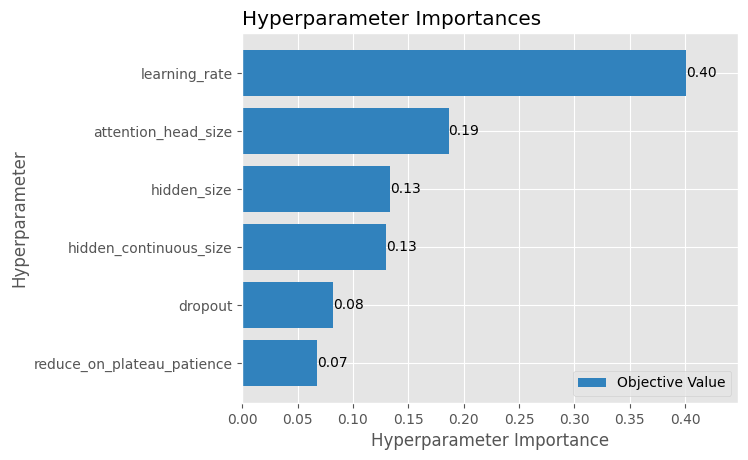

In [7]:
# Encontrar o melhor learning rate inicial usando Tuner.lr_find()
suggested_lr = 2.951209226666385e-05

# Criar um espaço de busca ao redor do `suggested_lr`
lr_min = max(suggested_lr / 5, 1e-6)
lr_max = min(suggested_lr * 5, 1e-2)

print(f"Suggested Learning Rate: {suggested_lr}")
print(f"Adjusted LR Range for Optuna: {lr_min} - {lr_max}")

# Criando o estudo Optuna que minimiza o WMAE
study = optuna.create_study(direction="minimize")

# Número de tentativas para encontrar os melhores hiperparâmetros
n_trials = 10
cv = 1
epochs = 1

# Otimização dos hiperparâmetros
step = 1
for n in range(step, max(n_trials + 1, step), step):
    study.optimize(
        lambda trial: otimizar_tft(trial, df_sales_processed_transformer, lr_min, lr_max, cv, epochs),
        n_trials=10,
    )

    # Salvar estudo para continuar de onde parou
    joblib.dump(study, "../reports/optuna/tft_study.pkl")
    time.sleep(5)  # Para evitar sobrecarga de GPU

print(f"Melhores hiperparâmetros encontrados: {study.best_params}")

# Visualizando a importância dos hiperparâmetros
_ = plot_param_importances(study)

## Treinamento e salvamento do modelo TFT com os melhores hiperparâmetros encontrados

In [ ]:
# Criar diretório para salvar o modelo final
model_dir = "../models/final/"
study_dir = "../reports/optuna/"

# Carregar os melhores hiperparâmetros do estudo Optuna
study = joblib.load(os.path.join(study_dir, "tft_study.pkl"))

# Carregar os melhores hiperparâmetros do estudo Optuna
best_params = study.best_params

# Usar os melhores hiperparâmetros encontrados para treinar o modelo final
training_df, validation_df, test_df = expanding_window_split(
    df_sales_processed_transformer, 0, validation=True
)

# Criando TimeSeriesDataSet para treino
dados_treino = TimeSeriesDataSet(
    training_df,
    time_idx="time_idx",
    target="sales",
    group_ids=["series_id"],
    min_encoder_length=168 // 2,
    max_encoder_length=168,
    static_categoricals=["series_id"],
    min_prediction_length=1,
    max_prediction_length=28,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["sales"],
)

# Criando TimeSeriesDataSet para validação
dados_valid = TimeSeriesDataSet.from_dataset(
    dados_treino,
    pd.concat([training_df, validation_df]).reset_index(drop=True),
    predict=True,
    stop_randomization=True,
)

# Criando DataLoaders
dl_treino = dados_treino.to_dataloader(train=True, batch_size=32, num_workers=2, pin_memory=True)
dl_valid = dados_valid.to_dataloader(train=False, batch_size=32, num_workers=2, pin_memory=True)

# Configuração do Trainer
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
)

# Criando e treinando o modelo TFT com os melhores hiperparâmetros encontrados
modelo_tft = TemporalFusionTransformer.from_dataset(
    dados_treino,
    learning_rate=best_params["learning_rate"],
    hidden_size=best_params["hidden_size"],
    attention_head_size=best_params["attention_head_size"],
    dropout=best_params["dropout"],
    hidden_continuous_size=best_params["hidden_continuous_size"],
    output_size=3,  # Para os quantis 0.1, 0.5 e 0.9
    loss=QuantileLoss([0.1, 0.5, 0.9]),
    reduce_on_plateau_patience=best_params["reduce_on_plateau_patience"],
)

# Treinamento final do modelo
trainer.fit(modelo_tft, train_dataloaders=dl_treino, val_dataloaders=dl_valid)

# Salvar o modelo final completo (não apenas checkpoint)
final_model_path = os.path.join(model_dir, "tft_model.ckpt")
trainer.save_checkpoint(final_model_path)

print(f"Modelo final salvo em: {final_model_path}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 1.3 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 51.2 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 102 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 50.5 K | train
7  | static_cont

Epoch 19: 100%|██████████| 59/59 [00:28<00:00,  2.08it/s, v_num=158, train_loss_step=791.0, val_loss=919.0, train_loss_epoch=788.0]    

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 59/59 [00:28<00:00,  2.07it/s, v_num=158, train_loss_step=791.0, val_loss=919.0, train_loss_epoch=788.0]
✅ Modelo final salvo em: ../models/final/tft_model.ckpt
